# CMB Lensing and quadratic estimator tutorial 
_Louis Legrand, with some help from Julien Carron and Sebastian Belkner_


This tutorial is an introduction to a CMB lensing reconstruction pipeline. We will learn how to make lensed simulations of the CMB and how to run a quadratic estimator on these maps to get an estimate of the lensing potential field. 

A general lensing reconstruction pipeline can be summarized as below (image credits A.Lewis):

![flow](img/flow.png)

Here we will play a bit with **healpy** to generate CMB maps and we will use **lenspyx** to lens them. We will use **plancklens** to run a QE and estimate the CMB lensing potential. From there we will estimate the lensing spectrum, it's normalization and the see how we can debias it.


In [1]:
%matplotlib inline

import os
import healpy as hp
import numpy as np
from os.path import join as opj


import lenspyx
import plancklens
from plancklens import utils
from plancklens import qest, qresp
from plancklens import nhl
from plancklens.n1 import n1
from plancklens.helpers.cachers import cacher_npy

from matplotlib import pyplot as plt
import matplotlib as mpl



In [2]:
# Maplotlib settings

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [3]:
# Useful functions for plotting spectra

def f(ell):
    """To plot l(l+1)/2pi CMB spectra """
    return ell*(ell+1)/2/np.pi

def pp2kk(ell):
    """Convert Cl^{\phi, \phi} into Cl^{\kappa, \kappa}"""
    return (ell*(ell+1))**2/4



# 1 - Preliminary settings 

In [4]:
# If you didn't set the PLENS environement variable, we do it here
if 'PLENS' not in os.environ.keys():
    os.environ['PLENS'] = 'plens_write'

In [5]:
TEMP =  opj(os.environ['PLENS'], 'lensing_tutorial')
print(TEMP)
# Some things will be cached in this TEMP directory.
# plancklens uses hashckecks to raise errors when parameters are updated and do not match the data in cache 
# In this case it is safer to change the TEMP directory to be sure to not mess things around



/Users/louis/Code/plancklens/plens_write/lensing_tutorial


In [6]:
# We will generate random realisations of the CMB
# We set the numpy random seed to avoid recomputing the lensed maps whan restarting the notebook 

seed = 123456 # Choose your favorite number
np.random.seed(seed)

# We will save our map realisations in this TEMP directory 
cacher = cacher_npy(os.path.join(TEMP, f'seed_{seed}'))

# 2 - Generate the unlensed CMB maps and the lensing potential map

This step is described in more details in the [tuto_lensmap](./tuto_lensmap.ipynb) notebook. We wont spend too much time on this as this is not the major point of the lensing reconstruction, but have a look if you are interested.

In [7]:
# CMB spectra used to generate the simulations

cls_path = opj(os.path.dirname(os.path.abspath(plancklens.__file__)), 'data', 'cls')

cl_unl = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))

**Note:** In our notebook we will use the same spectra to generate the simulations and to make the analysis, but in practice they could be different as we dont know the real spectra of the observed CMB. 
In a standard analysis we correct for this mismatch at a later stage by debiasing the reconstructed lensing power spectrum.
In our idealized simulation case we won't need that.

In [8]:
# This parameter set the maximum scale used to generate the CMB maps
lmax_sky = 6000

In [9]:
alms_arr = hp.synalm([cl_unl['tt'], cl_unl['te'], None, cl_unl['pt'], 
    cl_unl['ee'], None, cl_unl['pe'], cl_unl['bb'], None, cl_unl['pp'] ], new=False, lmax=lmax_sky)


In [10]:
alms = {'t':alms_arr[0], 'e':alms_arr[1], 'b':alms_arr[2], 'p':alms_arr[3]}

# 3 - Lens the CMB maps

We will use the **lenspyx** package to lens the CMB maps we generated.

The lensing operation is defined by 
\begin{equation}
X^{\rm len}(\boldsymbol{\hat n}) = X^{\rm unl}(\boldsymbol{\hat n} + \boldsymbol{d}(\boldsymbol{\hat n}))
\end{equation}
where $X\in[T, Q, U]$ and $\boldsymbol{d}$ is the deflection vector field.
We usually decompose it into a potential $\phi$ and curl $\omega$ terms: $\boldsymbol{d} = \vec \nabla \phi + \vec\nabla \times (\omega \hat e_z)$. In the Born approximation (ie. we assuming there is just one lensing plane), the curl term vanishes.
We will also introduce the convergence field $\kappa \equiv -\frac{1}{2} \Delta \phi = -\frac{1}{2} \vec \nabla \cdot\boldsymbol{d}$.


In practice, in **lenspyx**, the lensing operation defined above is a remapping of the pixels of the CMB maps, this is done with an interpolation of the grid.


In [11]:
# parameters which impact of the accuracy of the result (and the execution time):

lmax_out = 2048  # desired lmax of the lensed field.
nside_lens = 2048 # The lensed tlm's are computed with healpy map2alm from a lensed map at resolution 'nside_lens'
facres = -1 # the deflected map is constructed by interpolation of the undeflected map,
           # built at target resolution ~ :math:`0.7 * 2^{-\rm facres}.` arcmin

We first transform the lensing potential field into a spin-1 deflection field. 

In [12]:
dlm = hp.almxfl(alms['p'], np.sqrt(np.arange(lmax_out + 1, dtype=float) * np.arange(1, lmax_out + 2)))

We now deflect the temperature map. Lenspyx deflect the temperature field at the map level, so the output is an healpix map with nside = nside_lens.
The result of the lensing operation is cached to avoid recomputing it the next time.


**Note:** We now focus on the temperature filed only, but as an exercise you can do the same on the polarisation fields, and reconstruct the lensing potential with the full T, E and B fields. You will see that the lensing creates B mode signal.

In [13]:
fn_tlens = 'tmap_len'

if not cacher.is_cached(fn_tlens):
    Tlen  = lenspyx.alm2lenmap(alms['t'], [dlm, None], nside_lens, facres=facres)
    cacher.cache(fn_tlens, Tlen)
Tlen = cacher.load(fn_tlens)

Let's compare the lensed map we generated with the unlensed one. 

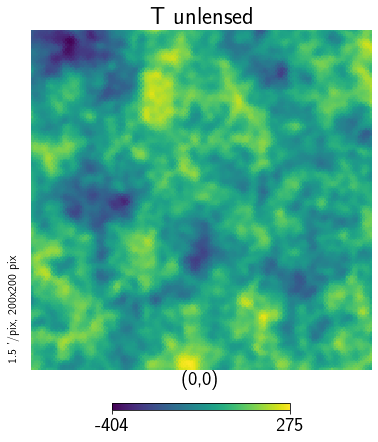

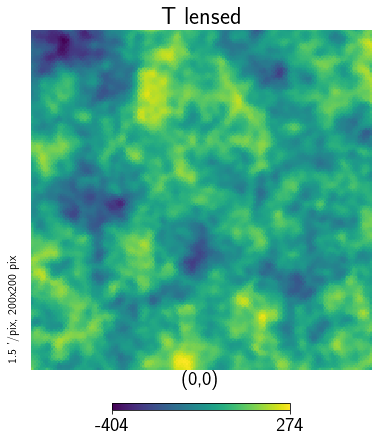

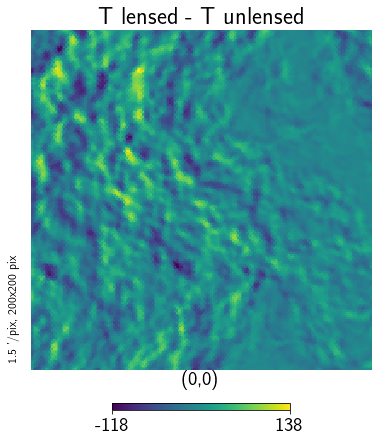

In [14]:
hp.gnomview(hp.alm2map(alms['t'], nside=nside_lens), title='T unlensed')
hp.gnomview(Tlen, title='T lensed')
hp.gnomview(Tlen- hp.alm2map(alms['t'], nside=nside_lens), title='T lensed - T unlensed')



We can compare the power spectrum of the lensed map with the fiducial lensed power spectrum

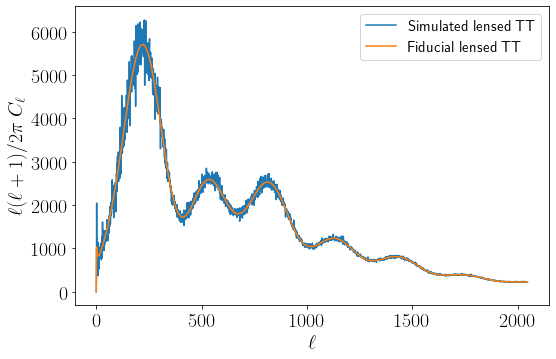

In [15]:
ell = np.arange(2048)

plt.plot(ell, f(ell)*hp.anafast(Tlen, lmax=ell[-1], iter=0), label='Simulated lensed TT')
plt.plot(ell, f(ell)*cl_len['tt'][ell], label='Fiducial lensed TT')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$ \ell(\ell+1)/ 2\pi \; C_\ell $')
plt.legend()


You can also compare the power spectrum of the lensed map with the unlensed map (left as a small exercise).

# 4- Beam and noise


We now simulate observed CMB maps by convolving the lensed maps with a gaussian beam (resolution of our instrument) and adding a white noise.

In [16]:
nlev_t = 5.  #Temperature noeise level in muK.arcmin
nlev_p = 5*np.sqrt(2.) #Polarisation noeise level in muK.arcmin (we wont use it here)

beam_fwhm_amin = 3. # Full width at half maximum of the gaussian beam of our instrument, in arcmin

lmax_ivf = 2048 
lmin_ivf = 10
# We will not the use the CMB modes outside of this interval
# IVF means inverse variance filter, this is an input of our quadratic estimator 


noise_lm = hp.synalm(np.ones(lmax_ivf+1)*(nlev_t*np.pi /180/60)**2)
# Noise spectrum

cl_beam = hp.gauss_beam(fwhm=beam_fwhm_amin*np.pi/180/60, lmax=lmax_ivf)
# Gaussian beam 


tlm = hp.map2alm(Tlen, iter=3, lmax=lmax_ivf)
hp.almxfl(tlm, cl_beam, inplace=True)
# Convolution with the beam

tobs_lm = tlm + noise_lm
# This is our observed temperature map

# 5 - Estimate the lensing potential field


Now that we have an observed temperature map, we can define a QE to reconstruct the lensing on this map.

Let X and Y be| two CMB maps that are lensed with the same lensing potential $\phi$. They can be either the temperature map T or the polarisation maps (Q and U).
The lensing field creates correlations between different scales. This can be described by: 

\begin{equation}
<X(\boldsymbol{l}_1)Y(\boldsymbol{l}_2)>_{\mathrm{fixed} \, \phi} = f_{XY}(\boldsymbol{l}_1, \boldsymbol{l}_2) \phi(\boldsymbol{L})
\end{equation}
for $\boldsymbol{l}_1 \neq \boldsymbol{l}_2$ and  $\boldsymbol{L} = \boldsymbol{l}_1 + \boldsymbol{l}_2$. This $f_{XY}$ function describes the coupling between the different scales created by lensing. 

For temperature only it is given by (see e.g. Manyiar et al. 2021)
\begin{equation}
f_{TT}(\boldsymbol{l}_1, \boldsymbol{l}_2) =  C_{l_1}^{TT} (\boldsymbol{L}\cdot \boldsymbol{l}_1) + C_{l_2}^{TT} (\boldsymbol{L}\cdot \boldsymbol{l}_2)
\end{equation}
where the $C_{l}^{TT}$ are the lensed CMB spectra (a more optimal estimator can be defined with the grad-lensed Cls).


In practice we only have one realization of the CMB, so we cannot average over it like in Eq. 1 to get the value of $\phi$. The best we can do is to define an estimator of $\phi$, and we will make sure it is be unbiased and has minimum variance.
We can define a generic estimator of $\phi$ by combining two maps (hence _quadratic_ estimator)
\begin{equation}
\hat \phi_{XY}(\boldsymbol{L}) = \frac{1}{R_{XY}(\boldsymbol{L})} \int_{\boldsymbol{L}=\boldsymbol{l}_1 + \boldsymbol{l}_2} \bar{X}_{\boldsymbol{l}_1} \bar{Y}_{\boldsymbol{l}_2} W_{XY}(\boldsymbol{l}_1, \boldsymbol{l}_2) \;
\end{equation}
with $\bar{X}$ and $\bar{Y}$ the inverse variance filtered CMB fields, $W_{XY}$ the weight of the estimator and $R_{XY}(\boldsymbol{L})$ the normalization which makes the estimator unbiased, i.e. $<\hat \phi_{XY}>_{\mathrm{fixed} \, \phi} = \phi$. 

The inverse variance filtered maps are given by 
\begin{equation}
\bar{X}_{\boldsymbol{l}} = \frac{X_{\boldsymbol{l}}}{C_l^{XX} + N_l^{XX}} = X_{\boldsymbol{l}}\mathrm{ftl}(l)
\end{equation}
with $  N_l^{TT}$ the noise spectrum of the map.

Using the Eq. 1, Hu and Okamoto 2002 introduced an unbiased and minimum variance estimator with $W_{XY} = f_{XY}$ and the reponse
\begin{equation}
R_{XY}(\boldsymbol{L}) =  \int_{\boldsymbol{L}=\boldsymbol{l}_1 + \boldsymbol{l}_2} [f_{XY}(\boldsymbol{l}_1, \boldsymbol{l}_2)] ^2 \mathrm{ftl}(l_1)\mathrm{ftl}(l_2) 
\end{equation}


**Note:** I have summarized here the QE in the flat sky approximation, where we identify spherical harmonics with Fourier modes. The curved sky equations (introduced in Okamoto and Hu 2003) are similar but a bit more complex. The **plancklens** module implements the curved sky QE (see Planck 2018 results VIII for the actual implementation).


Let us now implement the TT estimator (where X and Y are both the same field T) using the **plancklens** package. 

We start by defining the inverse variance filter of the temperature map.



In [17]:
cl_transf = cl_beam 
# The transfer function of our maps is the beam of the instrument
# In some configurations we should also take into account the pixel window function (given by hp.pixwin(nside_lens)), but we do not need it here 
# (in our simulations the pixel value is the value at the center of the pixel and not the average of the CMB inside the pixel).

ftl = utils.cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / cl_transf) ** 2)
ftl[:lmin_ivf] *= 0.
# This is the inverse variance filter
# It also sets the minimum and maximum scales of the CMB maps used in the reconstruction 


def get_alm_ivfs(x):
    """The eval_qe function of plancklens ask for a callable to access the filtered CMB maps"""
    if x =='t':
        return hp.almxfl(tobs_lm, ftl* utils.cli(cl_transf[:lmax_ivf+1]))
    else:
        return 0

We now define our estimator. 
The cls_weight below are the Cls that are used in the weight $W_{XY}$ of the estimator.

In [18]:
# We want to reconstruct the lensing potential field up to this lmax
lmax_qlm = 2048

In [19]:
cls_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))


The function below performs the quadratic estimation. 
The glm and the clm are respectively the gradient and the curl modes of the defelection field. 
In current CMB surveys, the curl modes are unobservable so they are often used as a consistency check. In our simulation they should be zero.

In **plancklens**, the estimator key tells which field we want to reconstruct and which combination of maps we want. 
Here we will use the 'ptt' key, the first p means we want to reconstruct $\phi$, and the 'tt' means we are using the temperature maps on both legs of the estimator. 

The function qest.eval_qe will solve for the inrtgral defined in teh Eq. 3 of the cell above, without the normalisation $R_{XY}$. In practice **plancklens** works in pixel space: the convolution of Eq. 3 in Fourier space becomes a product of filtered maps in real space.


In [20]:
key = 'ptt'

fn_glm = 'glm'
fn_clm = 'clm'

if not cacher.is_cached(fn_glm) or not cacher.is_cached(fn_clm):
    glm, clm = qest.eval_qe(key, lmax_ivf, cls_weight, get_alm_ivfs, nside=2048, lmax_qlm=lmax_qlm, verbose=True)
    cacher.cache(fn_glm, glm)
    cacher.cache(fn_clm, clm)
glm = cacher.load(fn_glm)
clm = cacher.load(fn_clm)


The functions below define the the response $R_{XY}$ of the estimator, which is used to normalise $\hat \phi$

In [21]:
#---- QE response calculation library:
qresp_dd = qresp.resp_lib_simple(os.path.join(TEMP, 'qresp'), lmax_ivf, cls_weight, cl_len,
                                 {'t': ftl}, lmax_qlm)

# Lensing response according to the fiducial cosmology:t
resp = qresp_dd.get_response(key, 'p')


# Estimator normalization is the inverse response:
qnorm = utils.cli(resp)                               

Let us now compare our estimated $\hat \phi$ with the input $\phi$ of our simulation !

In [22]:
plm_input = utils.alm_copy(alms['p'], lmax=lmax_qlm)

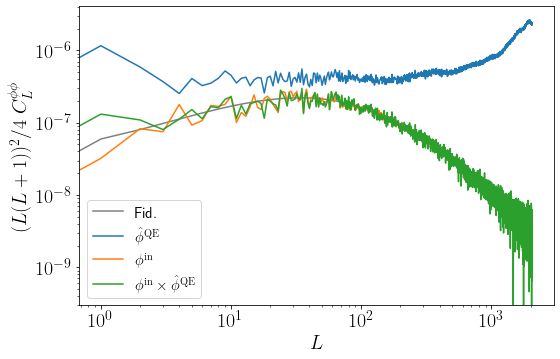

In [23]:
plt.plot(ell, pp2kk(ell) * cl_unl['pp'][ell], label='Fid.', c='grey')

plt.plot(ell, pp2kk(ell) * hp.alm2cl(glm)[ell]  * qnorm[ell] ** 2, label='$\hat \phi^\mathrm{QE}$')


plt.plot(ell, pp2kk(ell) * hp.alm2cl(plm_input)[ell], label='$\phi^\mathrm{in}$')


plt.plot(ell, pp2kk(ell) * hp.alm2cl(glm, plm_input)[ell] *qnorm[ell], label='$\phi^\mathrm{in} \\times \hat \phi^\mathrm{QE}$')

plt.loglog()


plt.xlabel(r'$L$')
plt.ylabel(r'$ (L(L+1))^2/ 4 \; C_L^{\phi \phi} $') 

plt.legend()

What do we see here ? Is the blue curve the spectrum we expect ? Why is it so bad ?

# 6 - Debiasing the QE spectrum 

As you can see above, the auto spectrum of the $\hat \phi$ seems to be totally biased. This is due to the fact that the QE will take all correlations between different CMB scales as due to lensing. In the CMB there are random correlations between different scales, and the QE will think they are due to lensing.
This is known as the $N_L^{(0)}$ bias, and it can be estimated analytically. When the weights used in the estimator are the same as the CMB response, then we have $N_L^{(0)} = 1/R_L$.

We use plancklens to get an estimate of this $N_L^{(0)}$.


In [24]:
N0s =  nhl.get_nhl(key, key, cls_weight, {'tt':ftl}, lmax_ivf, lmax_ivf )

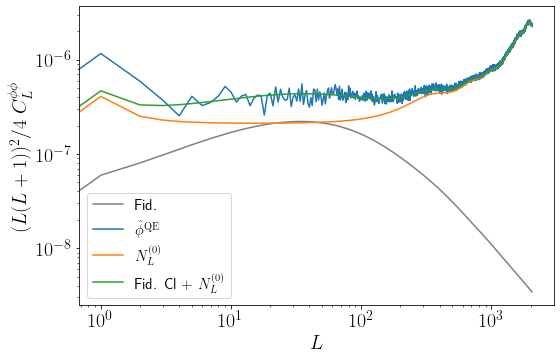

In [25]:

plt.plot(ell, pp2kk(ell) * cl_unl['pp'][ell], label='Fid.', c='grey')

plt.plot(ell, pp2kk(ell) * hp.alm2cl(glm)[ell]  * qnorm[ell] ** 2, label='$\hat \phi^\mathrm{QE}$')

plt.plot(ell, pp2kk(ell)*N0s[0][ell]* qnorm[ell] ** 2., label='$N_L^{(0)}$')


# plt.plot(ell, pp2kk(ell) * (hp.alm2cl(glm)[ell] -N0s[0][ell]) * qnorm[ell] ** 2, label='$\hat \phi^\mathrm{QE} - N_L^{(0)}$')

plt.plot(ell, pp2kk(ell) * (cl_unl['pp'][ell] + N0s[0][ell]* qnorm[ell] ** 2), label='Fid. Cl + $N_L^{(0)}$')


plt.loglog()


plt.xlabel(r'$L$')
plt.ylabel(r'$ (L(L+1))^2/ 4 \; C_L^{\phi \phi} $') 

plt.legend()

We now have an estimator of the lensing power spectrum which can be debiased. 

There are higher order bias terms, such as $N_L^{(1)}$ due to CMB correlations which are created by lensing, or $N_L^{(3/2)}$ which arise due to the non gaussianity of the LSS. 

To perform a realistic analysis we would have to take into account the mask of the survey. This creates also a signal in the QE which is called the mean field, it is the response of the QE to the mask. We can estimate it using simulations of the experiment, and subtract it from our $\hat \phi$ estimate. 

All the ingredients we put in the lensing reconstruction are fiducial ones: in practice we don't know exactly the CMB spectra, nor the beam or the noise level of our instrument. 
This is taken into account in a realization dependent debiaser. 

# 7 - Realization dependent debiaser 

Let's use the same simulation with the same input spectra, but reconstruct the lensing potential with a QE using biased fiducial ingredients.

Using the biased ingredients to estimate the N0 bias will get us a biased estimate of teh power spectrum. 
But we can use a realization dependent debiaser, which combines the true spectra of the map with the biased fiducials. We can show that this debiased is robust in the mismatch between the data and the fiducial assumptions.


We will assume that the CMB Cls are 10 % lower than the true Cls.
This would be a huge mismatch because CMB Cls are known at much better than 10%.


In [26]:
bias = 0.9

cl_biased = {}
for k in ['tt', 'te', 'ee']:
    cl_biased[k] = cl_len[k] * bias


ftl_b = utils.cli(cl_biased['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / cl_transf) ** 2)
ftl_b[:lmin_ivf] *= 0.
# This is the inverse variance filter
# It also sets the minimum and maximum scales of the CMB maps used in the reconstruction 


def get_alm_ivfs_b(x):
    """The eval_qe function of plancklens ask for a callable to access the filtered CMB maps"""
    if x =='t':
        return hp.almxfl(tobs_lm, ftl_b* utils.cli(cl_transf[:lmax_ivf+1]))
    else:
        return 0


glm_b, _ = qest.eval_qe(key, lmax_ivf, cl_biased, get_alm_ivfs_b, nside=2048, lmax_qlm=lmax_qlm, verbose=True)


QE 1 out of 1 :
in-spins 1st leg and out-spin [0] 0
in-spins 2nd leg and out-spin [0] 1


In [27]:
#---- QE response calculation library:
qresp_dd = qresp.resp_lib_simple(os.path.join(TEMP, 'qresp_b' +str(bias)), lmax_ivf, cl_biased, cl_biased,
                                 {'t': ftl_b}, lmax_qlm)

# Lensing response according to the fiducial cosmology:t
resp = qresp_dd.get_response(key, 'p')


# Estimator normalization is the inverse response:
qnorm = utils.cli(resp)  

In [28]:
N0s =  nhl.get_nhl(key, key, cl_biased, {'tt':ftl_b}, lmax_ivf, lmax_ivf )

# We use a semi analytical RD-N0 debiaser, using the IVF data spectrum in the N0 estimate 
RDN0s =  nhl.get_nhl(key, key, cl_biased, {'tt': hp.alm2cl(get_alm_ivfs_b('t'))}, lmax_ivf, lmax_ivf )

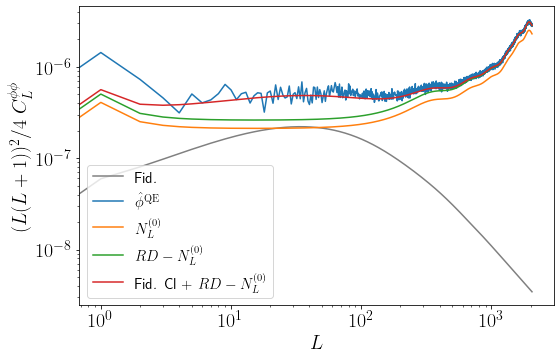

In [29]:

plt.plot(ell, pp2kk(ell) * cl_unl['pp'][ell], label='Fid.', c='grey')

plt.plot(ell, pp2kk(ell) * hp.alm2cl(glm_b)[ell]  * qnorm[ell] ** 2, label='$\hat \phi^\mathrm{QE}$')

plt.plot(ell, pp2kk(ell)*N0s[0][ell]* qnorm[ell] ** 2., label='$N_L^{(0)}$')
plt.plot(ell, pp2kk(ell)*RDN0s[0][ell]* qnorm[ell]**2, label='$RD-N_L^{(0)}$')



plt.plot(ell, pp2kk(ell) * (cl_unl['pp'][ell] + RDN0s[0][ell]* qnorm[ell] ** 2), label='Fid. Cl + $RD-N_L^{(0)}$')


plt.loglog()


plt.xlabel(r'$L$')
plt.ylabel(r'$ (L(L+1))^2/ 4 \; C_L^{\phi \phi} $') 

plt.legend()

Why is the orange curve totally off compared to the blue one ? 
Are we happy with the red one ?

If you wish to continue, you can now build the QE estimator using polarisation maps. Do not hesitate to ask me more information about this.